In [1]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn import decomposition
import gym

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [44]:
envname = 'MountainCarContinuous-v0'
# envname = 'Pendulum-v0'
demo_file = open('./'+envname+'-demo.pkl', 'rb')
demonstrations = pickle.load(demo_file)[0]

In [58]:
class VariationalAuotoEncoder(object):
    def __init__(self, obs_dim, hdim = 16, ldim = 4, epochs = 10000, lr = 1e-5):
        self.obs_dim = obs_dim
        
        self.seed = 0
        self.epochs = epochs
        
        self.lr = lr
        self.hdim = hdim
        self.ldim = ldim
        
        self.std = 1e-1
        
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._vae_nn()
            self._loss_train_op()
            self.init = tf.global_variables_initializer()
            
    def _placeholders(self):
        # observations, actions and advantages:
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.latent_ph = tf.placeholder(tf.float32, (None, self.ldim), 'latent')

        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'lr')

    def _vae_nn(self):
        self.latent_mean, self.latent_std = self._encoder(self.obs_ph)
        self.latent = self.latent_mean + self.latent_std*tf.random_normal(tf.shape(self.latent_mean))
        
        self.obs_recon = self._decoder(self.latent)
        self.obs_gen = self._decoder(self.latent_ph,reuse=True)
          
    def _encoder(self,obs,reuse=False):
        hid1_size = self.hdim
        hid2_size = self.hdim
        latent_size = self.ldim
        
        with tf.variable_scope("encoder"):
            out = tf.layers.dense(obs, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1",
                                  reuse=reuse)
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2",
                                  reuse=reuse)
            latent_mean = tf.layers.dense(out, latent_size,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), 
                                    name="latent_mean",reuse=reuse)
            latent_std_logits = tf.layers.dense(out, latent_size,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), 
                                    name="latent_std",reuse=reuse)
            latent_std = self.std*tf.sigmoid(latent_std_logits)
        return latent_mean, latent_std
    
    def _decoder(self,latent,reuse=False):
        hid1_size = self.hdim
        hid2_size = self.hdim
        
        with tf.variable_scope("decoder"):
            # Decoder for next state
            out = tf.layers.dense(latent, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1",
                                  reuse=reuse)
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2",
                                  reuse=reuse)
            obs = tf.layers.dense(out, self.obs_dim,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), 
                                    name="obs",reuse=reuse)
        return obs
        
    def _loss_train_op(self):
        reconstruction_loss = tf.reduce_sum(tf.squared_difference(self.obs_recon,self.obs_ph))
        kl_loss = -0.5 * tf.reduce_sum(1 + tf.log(self.latent_std) - tf.square(self.latent_mean) - tf.square(self.latent_std), axis=1) 
        
        self.reconstruction_loss = tf.reduce_mean(reconstruction_loss)
        self.kl_loss = tf.reduce_mean(kl_loss)
        
        self.vae_loss = self.reconstruction_loss + self.kl_loss
        
        # OPTIMIZER 
        optimizer = tf.train.AdamOptimizer(self.lr_ph)
        self.train_op = optimizer.minimize(self.vae_loss)
    
    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)
        
    def encode(self,obs):
        return self.sess.run(self.latent_mean,feed_dict={self.obs_ph:obs})
    
    def decode(self,latent):
        return self.sess.run(self.obs_gen,feed_dict={self.latent_ph:latent})
        
    def train(self,obs,batch_size = 128):
    
        num_batches = max(obs.shape[0] // batch_size, 1)
        batch_size = obs.shape[0] // num_batches
        
        for e in range(self.epochs+1):
            obs = shuffle(obs,random_state=0)
            for j in range(num_batches):
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.obs_ph: obs[start:end,:],
                     self.lr_ph: self.lr}        
                self.sess.run(self.train_op, feed_dict)
            
            if (e%100)==0:
                feed_dict = {self.obs_ph: obs, self.lr_ph: self.lr} 
                vae_loss, kl_loss = self.sess.run([self.vae_loss,self.kl_loss], feed_dict)
                print('[{}/{}] Recon : {:.03f}, KL : {:.03f}'.format(e, self.epochs, vae_loss, kl_loss))
        return vae_loss

class LatentDynamics():
    def __init__(self, act_dim, hdim = 16, ldim = 4, epochs = 10000, lr = 1e-5):
        self.act_dim = act_dim
        
        self.seed = 0
        self.epochs = epochs
        
        self.lr = lr
        self.hdim = hdim
        self.ldim = ldim
        
        self.std = 1e-1
        
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._ldm_nn()
            self._loss_train_op()
            self.init = tf.global_variables_initializer()
            
    def _placeholders(self):
        # observations, actions and advantages:
        self.next_latent_ph = tf.placeholder(tf.float32, (None, self.ldim), 'next_latent')
        self.latent_ph = tf.placeholder(tf.float32, (None, self.ldim), 'latent')
        self.act_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'act')

        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'lr')

    def _ldm_nn(self):
        self.passive_dynamics, self.control_dynamics = self._dynamics(self.latent_ph)
        self.next_latent_predict = self.passive_dynamics + tf.reduce_sum(self.control_dynamics*tf.tile(self.act_ph[:,tf.newaxis,:],[1,self.ldim,1]))
        
        self.passive_dynamics_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="passive_dynamics")
        self.control_dynamics_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="control_dynamics")
            
    def _dynamics(self,latent,reuse=False):
        hid1_size = self.hdim
        latent_size = self.ldim
        
        with tf.variable_scope("passive_dynamics"):
            # Passive Dynamics
            out = tf.layers.dense(latent, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1",
                                  reuse=reuse)
            out = tf.layers.dense(out, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2",
                                  reuse=reuse)
            passive_dynamics = tf.layers.dense(out, latent_size,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="passive_dynamics",
                                  reuse=reuse)
        
        with tf.variable_scope("control_dynamics"):
            # Control Dynamics
            out = tf.layers.dense(latent, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1",
                                  reuse=reuse)
            out = tf.layers.dense(out, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2",
                                  reuse=reuse)
            out = tf.layers.dense(out, latent_size*self.act_dim,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="flatten_dynamics",
                                  reuse=reuse)
            control_dynamics = tf.reshape(out,[-1,latent_size,self.act_dim], name="control_dynamics")
            
        return passive_dynamics, control_dynamics
            
    def _loss_train_op(self):
        # Define Loss
        latent_prediction_loss = tf.reduce_sum(tf.square(self.next_latent_predict - self.next_latent_ph))
        
        self.dyn_loss = tf.reduce_mean(latent_prediction_loss)
        
        # OPTIMIZER 
        optimizer = tf.train.AdamOptimizer(self.lr_ph)
        self.train_op = optimizer.minimize(self.dyn_loss)
    
    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)
   
    def get_prediction(self,latent):
        next_latent = self.sess.run(self.next_latent_predict,feed_dict={self.latent_ph:latent})
        return next_latent
    
    def get_control_dynamics(self,latent):
        return self.sess.run(self.control_dynamics,feed_dict={self.latent_ph:latent})
            
    def train(self,latent,act,next_latent,batch_size = 128): # TRAIN POLICY
        
        num_batches = max(obs.shape[0] // batch_size, 1)
        batch_size = obs.shape[0] // num_batches
        
        for e in range(self.epochs+1):
            latent,act,next_latent = shuffle(latent,act,next_latent,random_state=0)
            for j in range(num_batches):
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.latent_ph: latent[start:end,:],
                     self.act_ph: act[start:end,:],
                     self.next_latent_ph: next_latent[start:end,:],
                     self.lr_ph: self.lr}        
                self.sess.run(self.train_op, feed_dict)
            
            if (e%100)==0:
                feed_dict = {self.latent_ph: latent,
                     self.act_ph: act,
                     self.next_latent_ph: next_latent,
                     self.lr_ph: self.lr}        
                dyn_loss = self.sess.run(self.dyn_loss, feed_dict)
                print('[{}/{}] Latent Prediction : {:.05f}'.
                      format(e, self.epochs, dyn_loss))
        return dyn_loss

In [63]:
env = gym.make(envname)

env.seed(seed=0)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

vae = VariationalAuotoEncoder(obs_dim)

/root/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [64]:
obs = np.concatenate([t['observes'][:-1] for t in demonstrations])
act = np.concatenate([t['actions'][:-1] for t in demonstrations])
next_obs = np.concatenate([t['observes'][1:] for t in demonstrations])
print(obs.shape)
print(act.shape)
print(next_obs.shape)

(4352, 2)
(4352, 1)
(4352, 2)


In [65]:
vae.epochs = 500
vae.train(obs)

[0/500] Recon : 1279.876, KL : 3.996
[100/500] Recon : 717.907, KL : 3.954
[200/500] Recon : 335.089, KL : 4.045
[300/500] Recon : 167.086, KL : 3.969
[400/500] Recon : 21.713, KL : 3.877
[500/500] Recon : 19.795, KL : 3.761


19.794594

In [72]:
latent = vae.encode(obs)
next_latent = vae.encode(next_obs)
ldm.lr = 1e-7
ldm.epochs = 1000
ldm.train(latent,act,next_latent)

[0/1000] Latent Prediction : 109.66037


KeyboardInterrupt: 

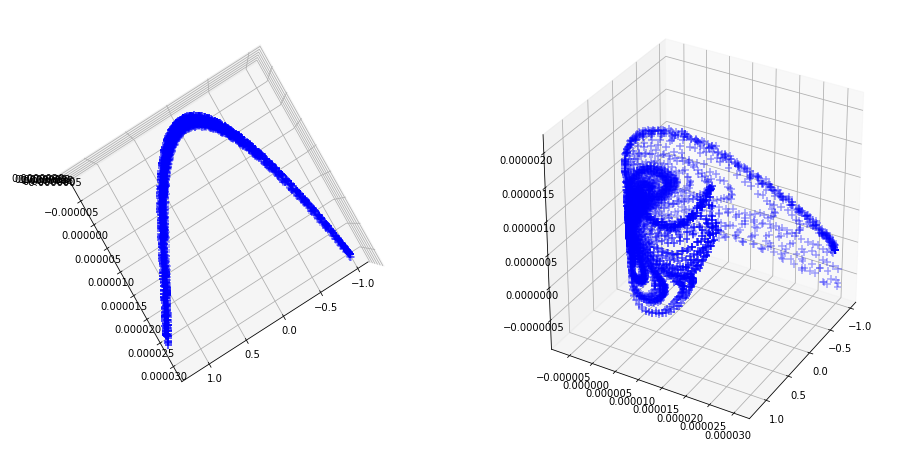

In [69]:
latent = vae.encode(obs)
pca = decomposition.PCA(n_components=3)
pca.fit(latent)
observes_demo_pca = pca.transform(latent)

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(121, projection='3d')
ax.view_init(90, 60)
plt.scatter(observes_demo_pca[:,0],observes_demo_pca[:,1],zs=observes_demo_pca[:,2],marker='+',linewidths=1,s=60,c='b')
ax = fig.add_subplot(122, projection='3d')
ax.view_init(30, 30)
plt.scatter(observes_demo_pca[:,0],observes_demo_pca[:,1],zs=observes_demo_pca[:,2],marker='+',linewidths=1,s=60,c='b')
plt.show()

In [77]:
class Value(object):
    def __init__(self, obs_dim, act_dim, hdim = 16, ldim = 4, epochs = 10000, lr = 1e-3):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.seed = 0
        self.epochs = epochs
        self.lr = lr
        self.hdim = hdim
        self.ldim = ldim
        
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn()
            self._loss_train_op()
            self.init = tf.global_variables_initializer()
            self.variables = tf.global_variables()
            
    def _placeholders(self):
        # observations, actions and advantages:
        self.latent_ph = tf.placeholder(tf.float32, (None, self.ldim), 'latent')
        self.control_dynamics_ph = tf.placeholder(tf.float32, (None, self.ldim, self.act_dim), 'control_dynamics')
        self.control_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'control')

        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'lr')

    def _policy_nn(self):
        
        hid1_size = self.hdim
        hid2_size = self.hdim
        latent_size = self.ldim
        
        with tf.variable_scope("value_network"):
            # Encoder
            out = tf.layers.dense(self.latent_ph, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1")
            out = tf.layers.dense(out, hid2_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2")
            self.value = tf.layers.dense(out, 1,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), 
                                    name="value")
            self.value_gradients = tf.gradients(self.value,self.latent_ph,name="value_grads")[0]
            self.control = - tf.reduce_sum(tf.tile(self.value_gradients[:,:,tf.newaxis],[1,1,self.act_dim])*self.control_dynamics_ph,axis=1)

    def _loss_train_op(self):        
        # Sum up
        loss = tf.square(self.control_ph - self.control)
        self.loss = tf.reduce_mean(loss)
        
        # OPTIMIZER 
        optimizer = tf.train.AdamOptimizer(self.lr_ph)
        self.train_op = optimizer.minimize(self.loss)
    
    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)
    
    def get_control(self,latent,control_dynamics):
        ctrl, val = self.sess.run([self.control, self.value],feed_dict={self.latent_ph:latent,self.control_dynamics_ph:control_dynamics})
        return ctrl, val
#     def get_prediction_trajectory(self,obs,actions):
        
#         for act in actions
    
    def train(self,latent,control_dynamics,control,batch_size = 128): # TRAIN POLICY
        
        num_batches = max(obs.shape[0] // batch_size, 1)
        batch_size = obs.shape[0] // num_batches
        
        for e in range(self.epochs+1):
            latent,control_dynamics,control = shuffle(latent,control_dynamics,control,random_state=0)
            for j in range(num_batches):
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.latent_ph: latent[start:end,:],
                     self.control_dynamics_ph: control_dynamics[start:end,:,:],
                     self.control_ph: control[start:end,:],
                     self.lr_ph: self.lr}        
                self.sess.run(self.train_op, feed_dict)
            
            if (e%100)==0:
                feed_dict = {self.latent_ph: latent,
                     self.control_dynamics_ph: control_dynamics,
                     self.control_ph: control}        
                loss = self.sess.run(self.loss, feed_dict)
                print('[{}/{}] Loss : {:f}'.
                      format(e, self.epochs, loss))
        return loss

In [78]:
value = Value(obs_dim,act_dim)

latent = vae.encode(obs)
control_dynamics = ldm.get_control_dynamics(latent)
value.epochs = 10000
value.train(latent,control_dynamics,act)

[0/10000] Loss : 0.782140
[100/10000] Loss : 0.663232
[200/10000] Loss : 0.658188
[300/10000] Loss : 0.639821
[400/10000] Loss : 0.633353
[500/10000] Loss : 0.629086
[600/10000] Loss : 0.629979
[700/10000] Loss : 0.624432
[800/10000] Loss : 0.624685
[900/10000] Loss : 0.622692
[1000/10000] Loss : 0.621379
[1100/10000] Loss : 0.620767
[1200/10000] Loss : 0.620211
[1300/10000] Loss : 0.619882
[1400/10000] Loss : 0.619775
[1500/10000] Loss : 0.619533
[1600/10000] Loss : 0.619075
[1700/10000] Loss : 0.618867
[1800/10000] Loss : 0.618971
[1900/10000] Loss : 0.620219
[2000/10000] Loss : 0.621115
[2100/10000] Loss : 0.618816
[2200/10000] Loss : 0.618322
[2300/10000] Loss : 0.618282
[2400/10000] Loss : 0.618245
[2500/10000] Loss : 0.617950
[2600/10000] Loss : 0.617677
[2700/10000] Loss : 0.617709
[2800/10000] Loss : 0.618613
[2900/10000] Loss : 0.617360
[3000/10000] Loss : 0.617307


KeyboardInterrupt: 

-17.04732116439632


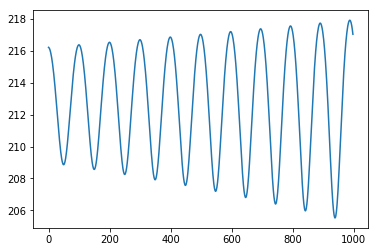

In [81]:
obs = env.reset()
rewards = []
vals = []
done = False
while not done:
    
    latent = vae.encode([obs])
    control_dynamic = ldm.get_control_dynamics(latent)
    action, val = value.get_control(latent,control_dynamic)
    
    obs, reward, done, info = env.step(action)
    obs = np.squeeze(obs)
    rewards.append(reward)
    vals.append(val[0][0])

print(np.sum(rewards))
plt.plot(vals)
plt.show()